### Import Dependencies

In [1]:
import os
import json
from glob import glob
from multiprocessing import Pool, cpu_count

from tqdm import tqdm

import numpy as np
import numpy.typing as npt
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

### Helper Functions

In [2]:
def plot_pitch_grid(data, title, label, fmt=".2f", cmap="magma", 
                    title_size=36, label_size=24, annot_size=20, tick_size=16):
    """
    Corrected helper function for plotting 2D heatmaps.
    """
    plt.style.use('dark_background')
    fig, ax = plt.subplots(figsize=(32, 18))

    sns.heatmap(
        data, 
        annot=True,      
        fmt=fmt,         
        cmap=cmap, 
        annot_kws={"size": annot_size},
        cbar_kws={'label': label},
        ax=ax
    )

    # Set Title and Axis Labels
    ax.set_title(title, fontsize=title_size, color='white', pad=30)
    ax.set_xlabel("Pitch Length (X-Grid)", fontsize=label_size, color='white')
    ax.set_ylabel("Pitch Width (Y-Grid)", fontsize=label_size, color='white')

    cbar = ax.collections[0].colorbar
    # Use set_label for the title and ax.tick_params for the numbers
    cbar.set_label(label, fontsize=label_size, color='white')
    cbar.ax.tick_params(labelsize=tick_size, colors='white')

    # Ensure the axis ticks are white and customizable
    ax.tick_params(colors='white', which='both', labelsize=tick_size)

    plt.show()

### Data Preprocessing

An xT model is fundamentally concerned with actions that actively change the ball’s location or directly attempt to convert threat into a shot.

The four event types retained here — **Pass**, **Carry**, **Dribble**, and **Shot** — are precisely the actions that drive this process. 

For this reason, we also restrict the analysis to **open-play** sequences, since including set-piece situations such as corners would artificially inflate threat values in fixed regions of the pitch that reflect restart structure rather than open-play ball progression.

In [3]:
XT_EVENT_TYPES = {
    "Pass",
    "Carry",
    "Dribble",
    "Shot",
}

def load_events(f):
    with open(f, "r") as fp:
        raw = json.load(fp)

    df = pd.json_normalize(raw, sep="_", max_level=2)
    df["match_id"] = os.path.basename(f).replace(".json", "")

    df = df[
        (df["play_pattern_name"] == "Regular Play") &
        (df["type_name"].isin(XT_EVENT_TYPES))
    ]

    return df

We use multiprocessing to speed up the ingestion of JSON files into a unified DataFrame.

In [4]:
event_files = glob("/home/liyi/Documents/project_kick/kick_lab/data/statsbomb_open_data/data/events/*.json")
test_files = event_files[:2000]  # We only check the first 2000 matches

with Pool(cpu_count()) as pool:
    filtered_list = list(
        tqdm(pool.imap(load_events, test_files),
             total=len(test_files),
             desc="Loading Matches")
    )

filtered_events = pd.concat(filtered_list, ignore_index=True)

Loading Matches: 100%|██████████| 2000/2000 [00:37<00:00, 53.35it/s]


### Feature Engineering

The Expected Threat (xT) model is built on the idea of **transitions**. In the StatsBomb dataset, a `Pass` has a *pass_end_location*. A `Carry` has a *carry_end_location*. However, a `Dribble` (taking on an opponent) **only records where the event occurred**. Therefore, we look ahead to the next event's starting position to determine where the ball moved.

$$
\text{End Location}_{\text{Dribble}_{i}} = \text{Start Location}_{\text{Event}_{i+1}}
$$

In [5]:
filtered_events = filtered_events.sort_values(
    ["match_id", "player_id", "index"]
)

next_loc = (
    filtered_events
    .groupby(["match_id", "player_id"])["location"]
    .shift(-1)
)

filtered_events = filtered_events.assign(
    next_start_x = next_loc.str[0],
    next_start_y = next_loc.str[1],
)

In [6]:
def build_action_df(df, action_type, start_col, end_col, result_func, is_list_end=True):
    """
    Generic builder for Pass, Carry, Shot, and Dribble action frames.
    """
    tmp = df[df["type_name"] == action_type].copy()

    # start location always list
    tmp["start_x"] = tmp[start_col].str[0]
    tmp["start_y"] = tmp[start_col].str[1]

    # end location: list or scalar
    if is_list_end:
        tmp["end_x"] = tmp[end_col].str[0]
        tmp["end_y"] = tmp[end_col].str[1]
    else:
        # end_col is name prefix like "next_start"
        tmp["end_x"] = tmp[end_col + "_x"]
        tmp["end_y"] = tmp[end_col + "_y"]

    # compute success: 0/1
    tmp["result"] = tmp.apply(result_func, axis=1)

    tmp["type_name"] = action_type

    return tmp[[
        "match_id", "team_id", "player_id", "index", "period",
        "start_x", "start_y", "end_x", "end_y",
        "result", "type_name"
    ]]

In [7]:
df_shot = build_action_df(
    filtered_events,
    action_type="Shot",
    start_col="location",
    end_col="shot_end_location",
    result_func=lambda r: 1 if r["shot_outcome_name"] == "Goal" else 0
)

df_pass = build_action_df(
    filtered_events,
    action_type="Pass",
    start_col="location",
    end_col="pass_end_location",
    result_func=lambda r: 1 if pd.isna(r["pass_outcome_name"]) else 0
)

df_carry = build_action_df(
    filtered_events,
    action_type="Carry",
    start_col="location",
    end_col="carry_end_location",
    result_func=lambda r: 1
)

df_dribble = build_action_df(
    filtered_events,
    action_type="Dribble",
    start_col="location",
    end_col="next_start",           
    result_func=lambda r: 1 if r["dribble_outcome_name"] == "Complete" else 0,
    is_list_end=False             
)

In [8]:
df_actions = pd.concat([df_pass, df_carry, df_dribble, df_shot], ignore_index=True)
df_actions = df_actions.dropna(subset=["end_x", "end_y"]).reset_index(drop=True)

type_map = {
    "Pass": 0,
    "Carry": 1,
    "Dribble": 2,
    "Shot": 3,
}
df_actions["type_id"] = df_actions["type_name"].map(type_map)
df_actions["result_id"] = df_actions["result"]

### Discretizing the Pitch 

The pitch is a **continuous space** (120×80 units), but we need to represent it as a finite set of states for our **Markov model**. We divide the pitch into an $N×M$ grid. Each $(x,y)$ coordinate is mapped to a specific cell index, which we then flatten into a single state $s$.

In [9]:
# Grid & Pitch Constants
M = 12   # rows (y)
N = 16   # cols (x)

PITCH_LENGTH = 120.0  # StatsBomb x
PITCH_WIDTH = 80.0    # StatsBomb y

In [10]:
def get_cell_indexes(
    x: pd.Series,
    y: pd.Series,
    l: int = N,
    w: int = M,
):
    xi = (x / PITCH_LENGTH * l).astype("int64").clip(0, l - 1)
    yj = (y / PITCH_WIDTH * w).astype("int64").clip(0, w - 1)
    return xi, yj


def get_flat_indexes(
    x: pd.Series,
    y: pd.Series,
    l: int = N,
    w: int = M,
) -> pd.Series:
    xi, yj = get_cell_indexes(x, y, l, w)
    return yj * l + xi

The following `count` function performs three essential operations:
- **Filtering**: It ignores events with missing coordinates (NaN) to prevent calculation errors.
- **Discretizatio**: It uses `get_flat_indexes` to translate every $(x,y)$ coordinate into a specific cell ID on our 12×16 grid.
- **Aggregation**: It tallies up every occurrence to create a "Population Map" of the pitch.

In [11]:
def count(
    x: pd.Series,
    y: pd.Series,
    l: int = N,
    w: int = M,
):
    """
    Count number of actions occurring in each cell of the grid.
    Returns a (w,l) matrix.
    """
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]

    flat_indexes = get_flat_indexes(x, y, l, w)
    vc = flat_indexes.value_counts(sort=False)

    vector = np.zeros(w * l, dtype=int)
    vector[vc.index] = vc
    return vector.reshape((w, l))

This heatmap down below visualizes the **spatial distribution** of all key actions (`Passes`, `Carries`, `Dribbles`, and `Shots`) within our discretized pitch. 

This serves as a critical data-quality check, ensuring we have sufficient event volume across the pitch to generate reliable Expected Threat values.

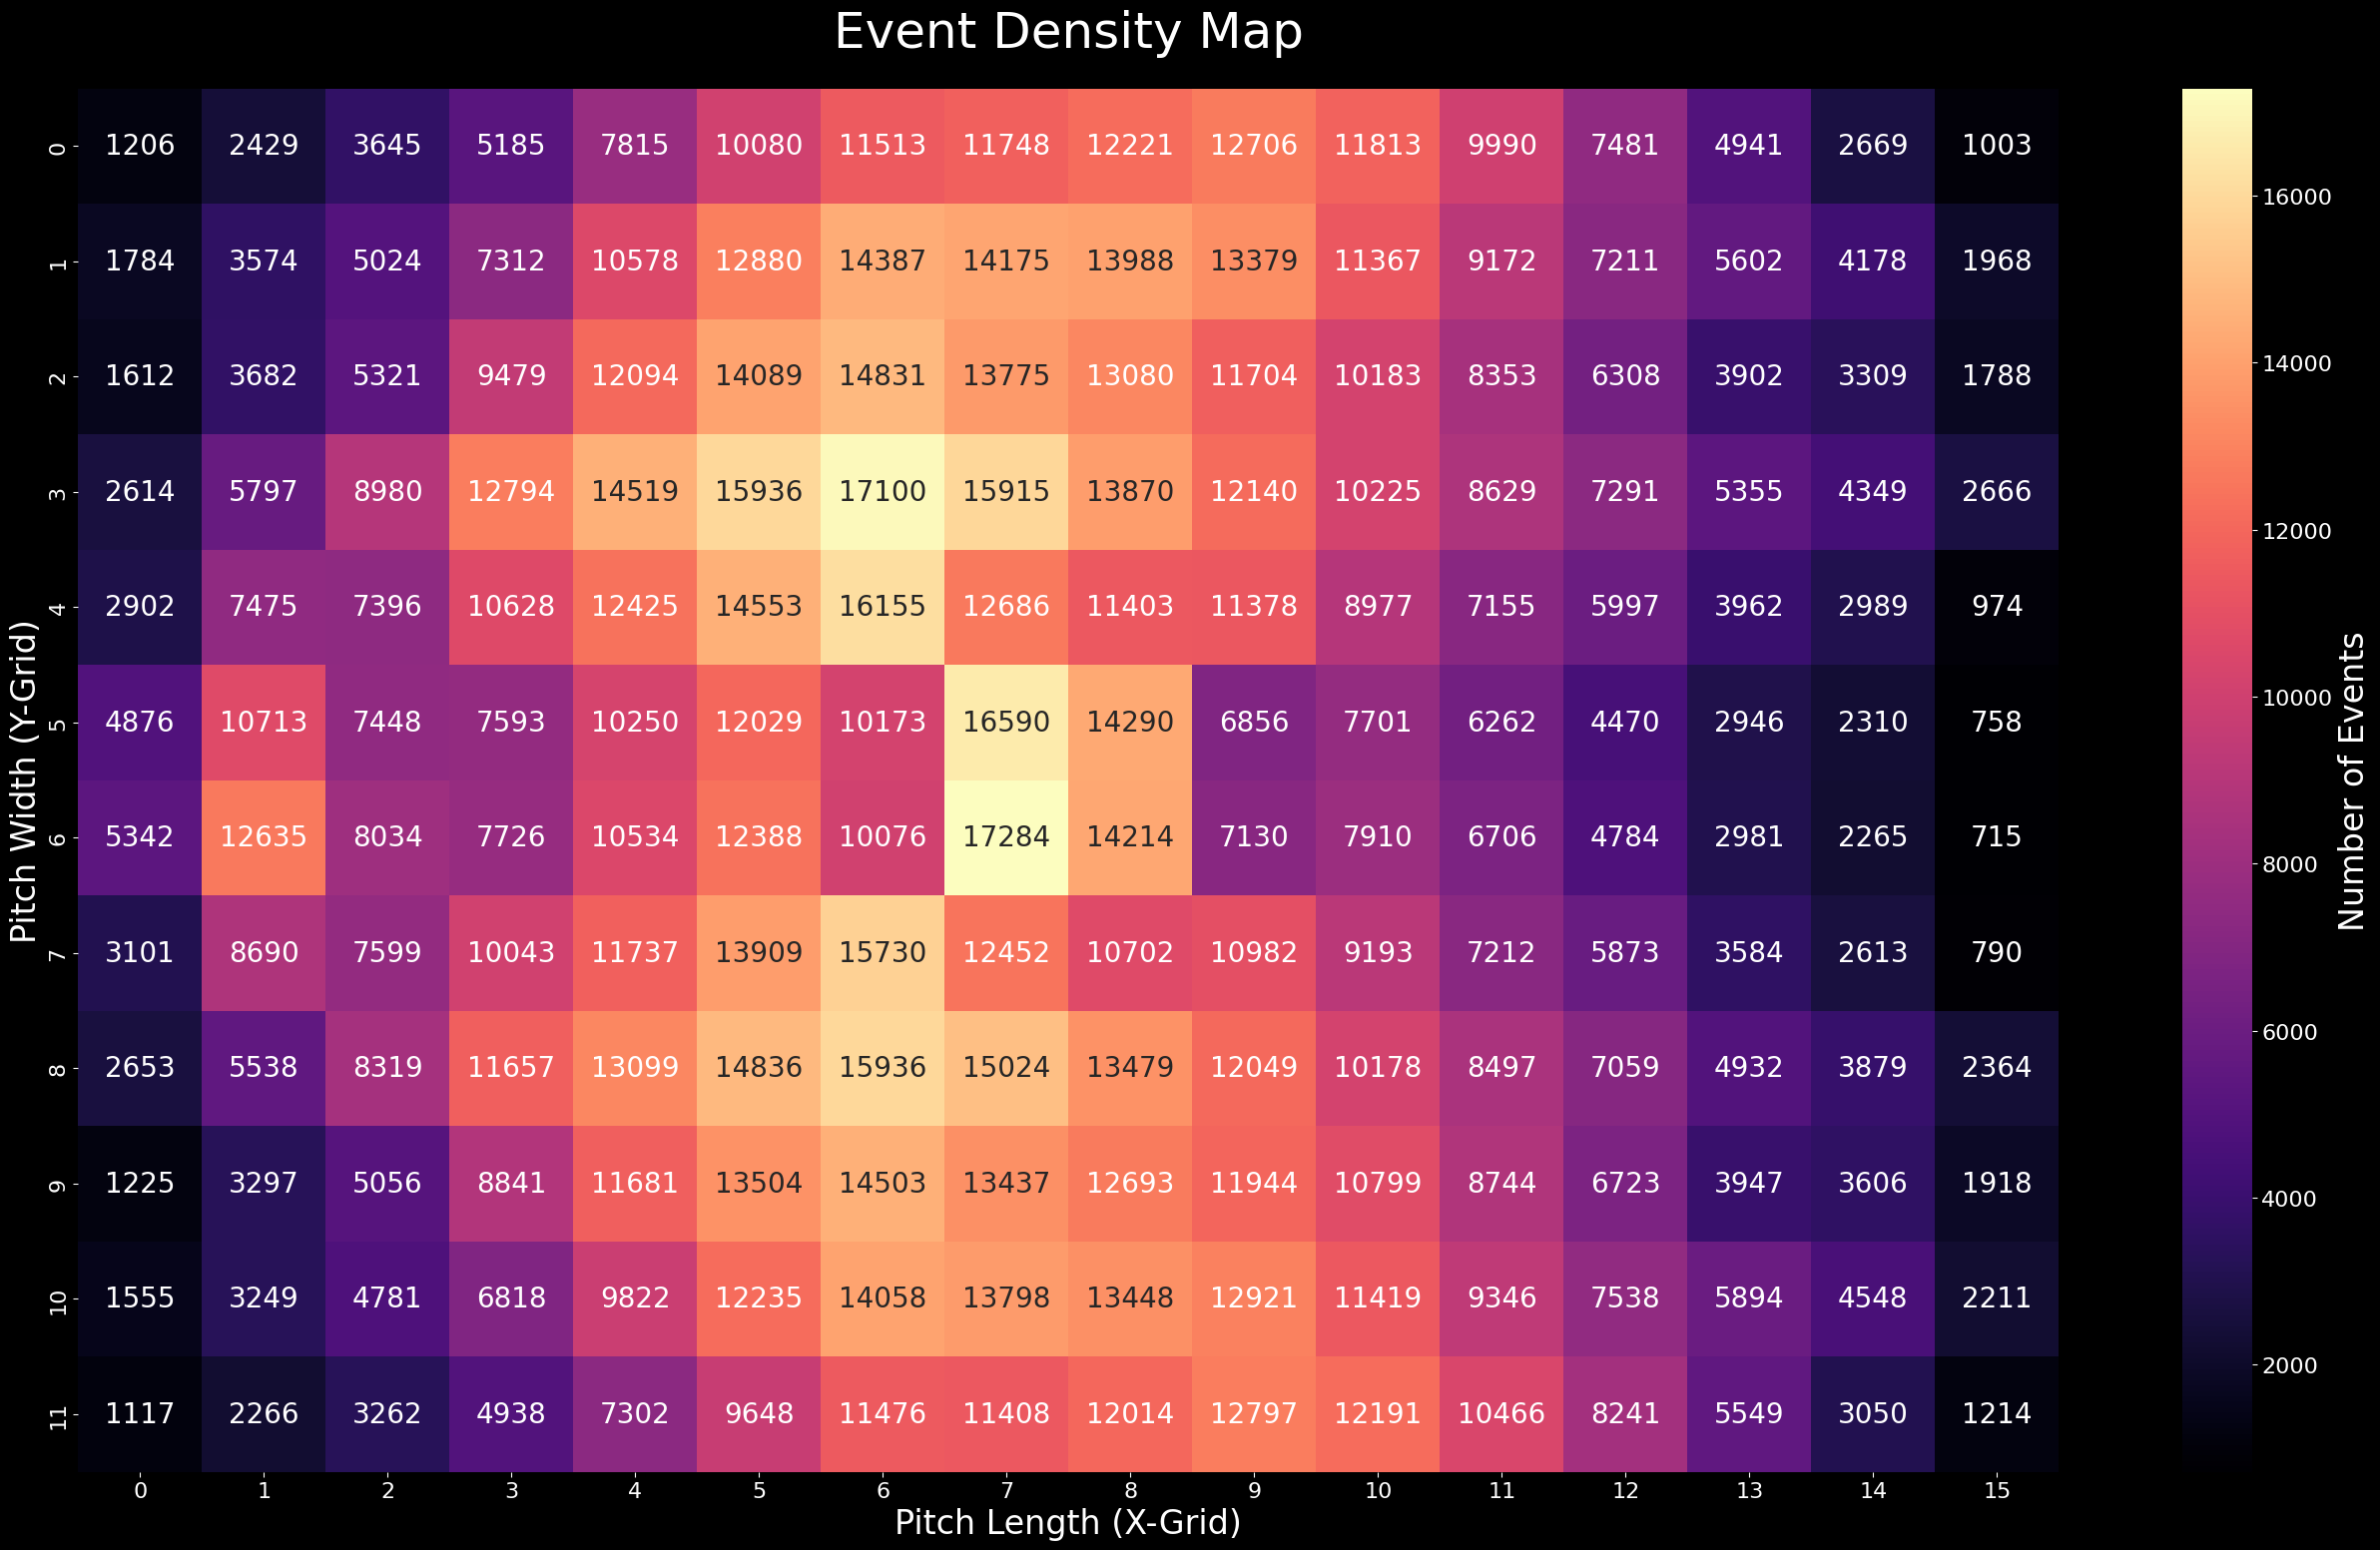

In [12]:
event_counts = count(df_actions["start_x"], df_actions["start_y"])

plot_pitch_grid(event_counts, "Event Density Map", "Number of Events", fmt="d")

### Calculating Immediate Reward

The core philosophy of the `Expected Threat` model is that the value of having the ball in a certain cell s is the sum of two distinct possibilities:
- The **Immediate Threat**: The probability of scoring right now by taking a shot.
- The **Future Threat**: The probability of moving the ball to a "better" cell and scoring from there in the future.

Mathematically, we solve for the value of each cell using this iterative Bellman equation:

$$
xT_s = \underbrace{(P(\text{Shot}|s) \times P(\text{Goal}|\text{Shot}, s))}_{\text{Immediate Reward}} + \underbrace{P(\text{Move}|s) \sum_{s' \in S} T(s \to s') xT_{s'}}_{\text{Expected Future Value}}
$$

Currently, we are focusing on the **Immediate Reward** $(g_s​)$. This is the portion of the equation that defines the "payoff" for being near the goal.

$$
g_s = P(\text{Shot}|s) \times P(\text{Goal}|\text{Shot}, s)
$$

To calculate this "*Goal Surface*," we are building the following two components:
- **Action Probabilities** $(P(Shot∣s))$: Determining if a player in cell $s$ is likely to shoot or move.
- **Scoring Probabilities** $(P(Goal∣Shot,s))$: Determining the historical success rate of shots from that specific cell.

In [13]:
SHOT_ID = 3           # type_id for Shot
MOVE_TYPE_IDS = {0,1,2}  # Pass, Carry, Dribble 

In [14]:
def safe_divide(a, b):
    """
    Element-wise divide, but return 0 where denominator is 0.
    """
    return np.divide(a, b, out=np.zeros_like(a, dtype="float64"), where=b != 0, casting="unsafe")

def get_scoring_prob(actions: pd.DataFrame, l: int = N, w: int = M):
    """
    Compute P(score | shoot from cell) as a (w,l) matrix.
    """
    shot_actions = actions[actions["type_id"] == SHOT_ID]
    goals = shot_actions[shot_actions["result_id"] == 1]

    shotmatrix = count(shot_actions["start_x"], shot_actions["start_y"], l, w)
    goalmatrix = count(goals["start_x"], goals["start_y"], l, w)

    return safe_divide(goalmatrix, shotmatrix)

In [15]:
def get_move_actions(actions: pd.DataFrame) -> pd.DataFrame:
    """
    All ball-progressing actions (pass, carry, dribble).
    """
    return actions[actions["type_id"].isin(MOVE_TYPE_IDS)]


def get_successful_move_actions(actions: pd.DataFrame) -> pd.DataFrame:
    """
    Successful ball-progressing actions only.
    """
    move_actions = get_move_actions(actions)
    return move_actions[move_actions["result_id"] == 1]


def get_action_prob(
    actions: pd.DataFrame,
    l: int = N,
    w: int = M,
):
    """
    For each cell, compute:
        P(shot | in cell), P(move | in cell)
    """
    move_actions = get_move_actions(actions)
    shot_actions = actions[actions["type_id"] == SHOT_ID]

    movematrix = count(move_actions["start_x"], move_actions["start_y"], l, w)
    shotmatrix = count(shot_actions["start_x"], shot_actions["start_y"], l, w)
    totalmatrix = movematrix + shotmatrix

    p_shot = safe_divide(shotmatrix, totalmatrix)
    p_move = safe_divide(movematrix, totalmatrix)
    return p_shot, p_move

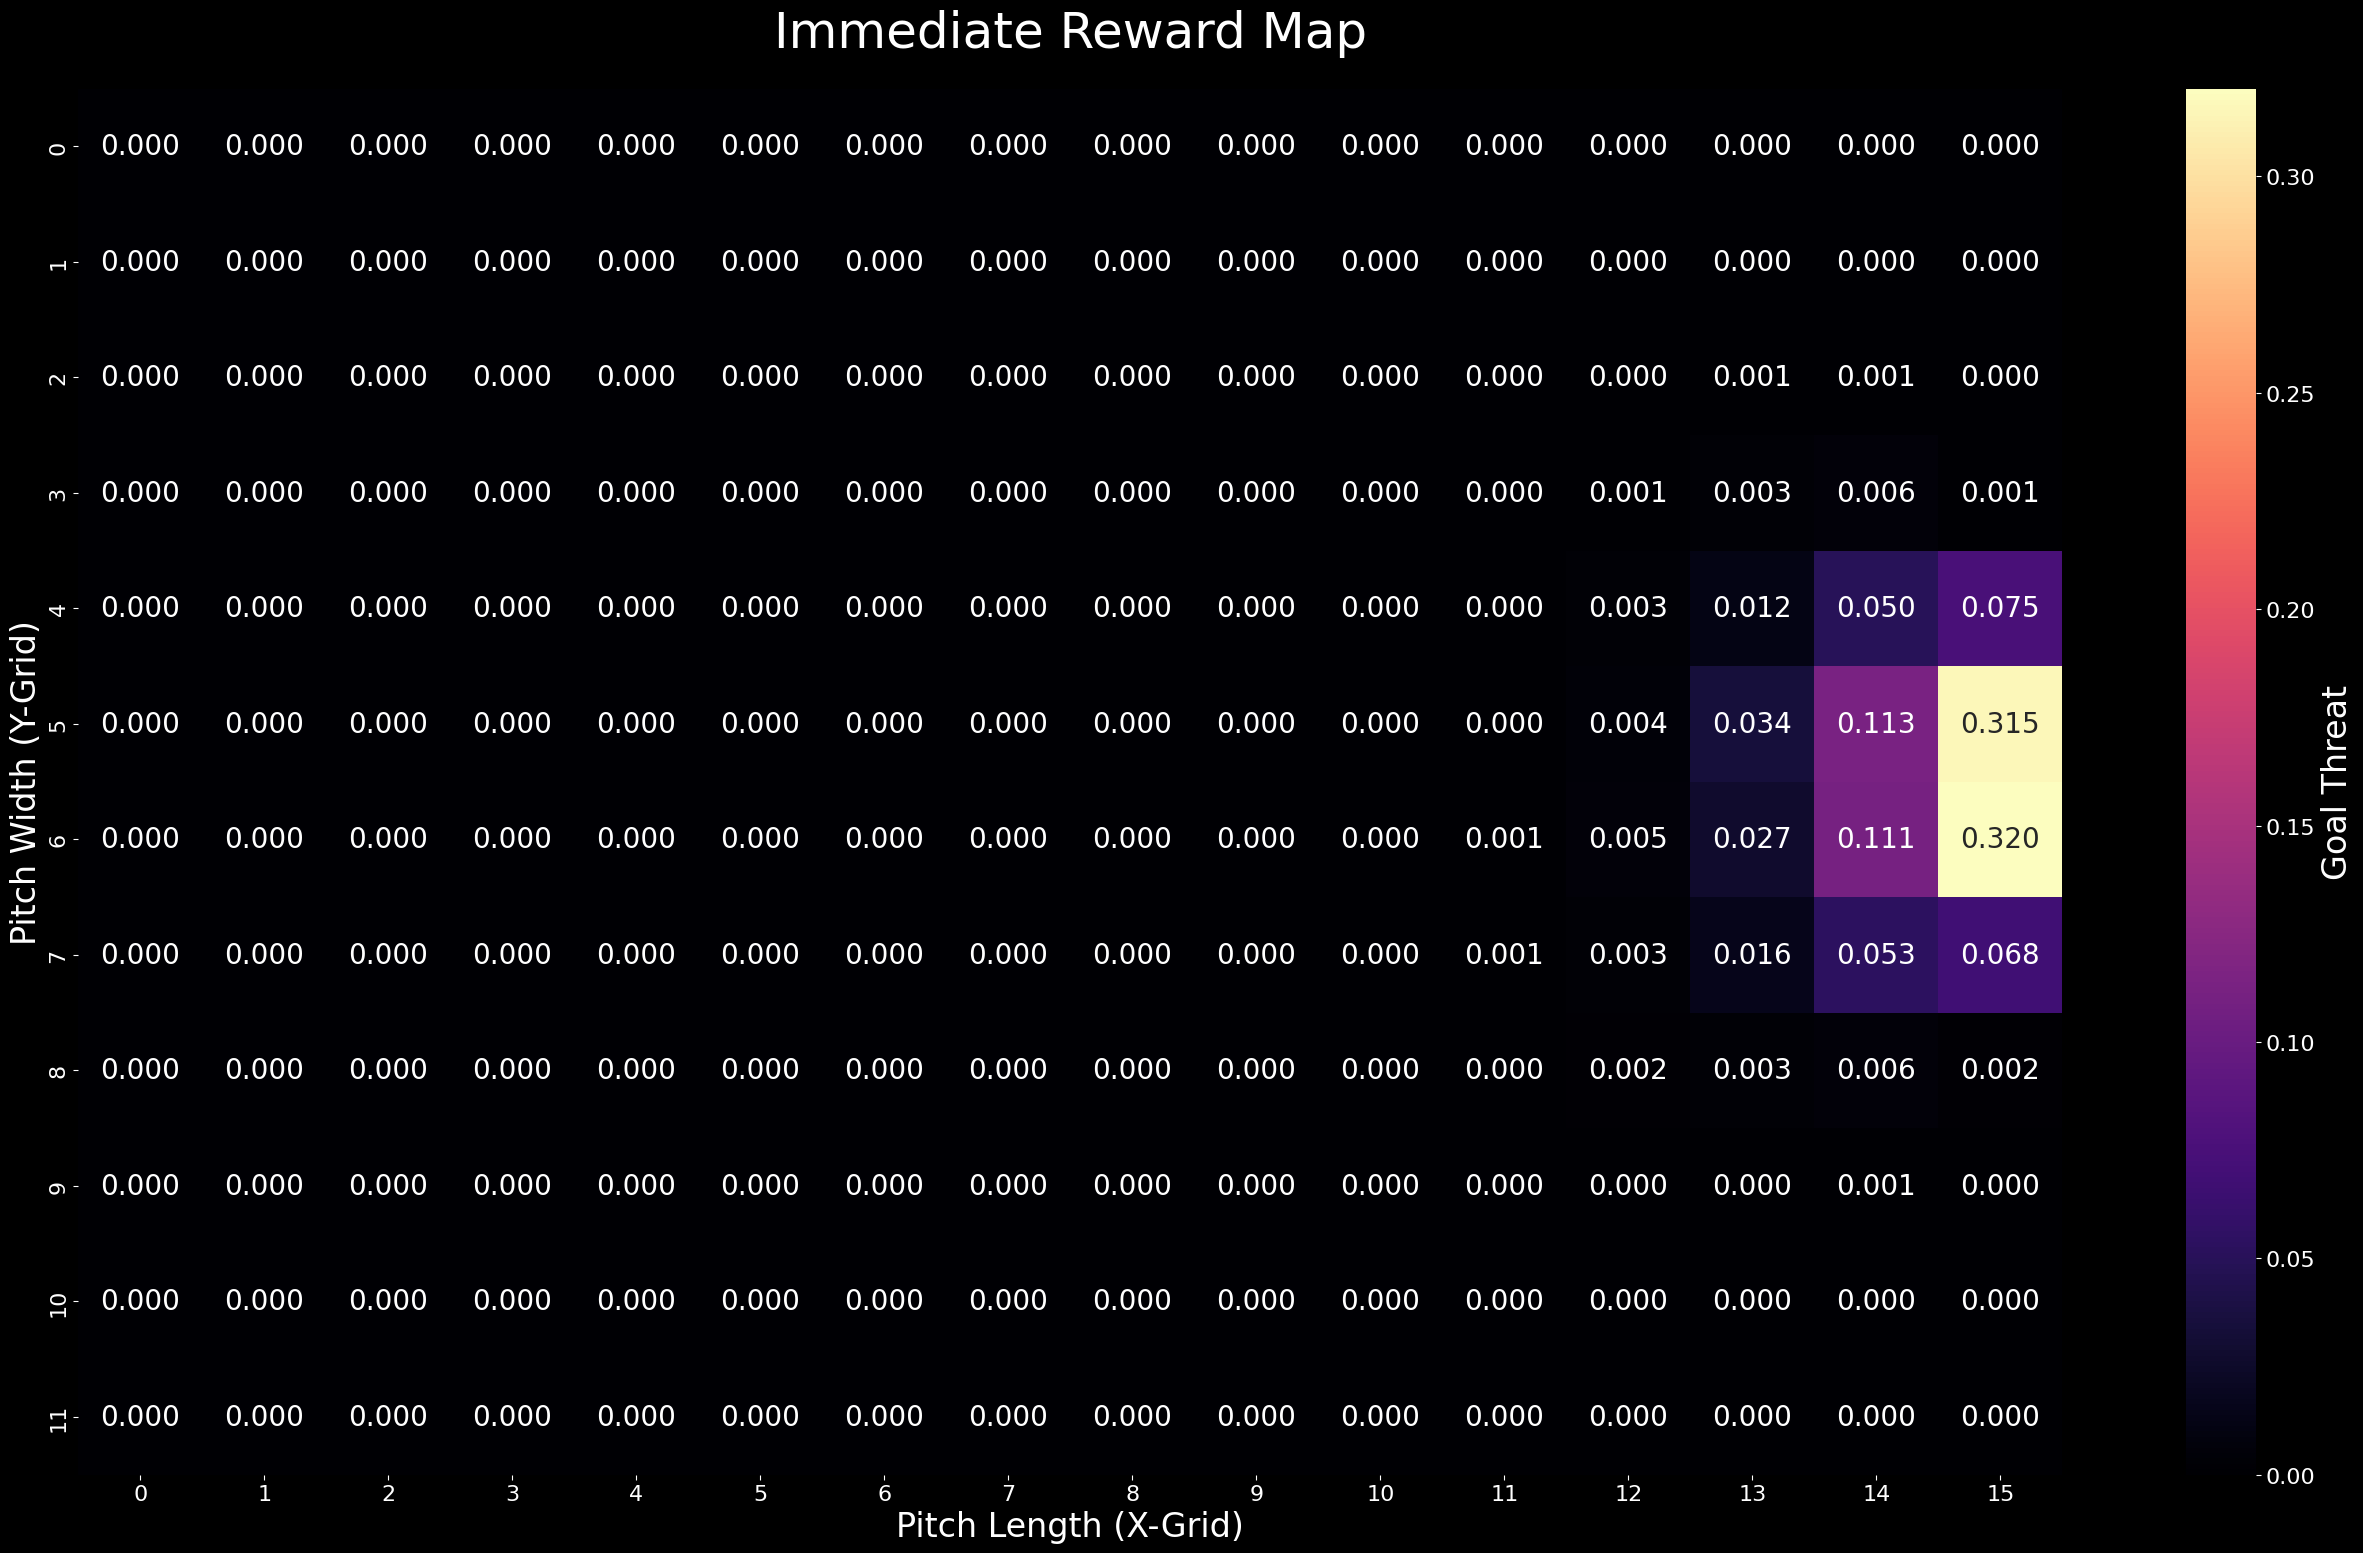

In [16]:
p_scoring = get_scoring_prob(df_actions)
p_shot, p_move = get_action_prob(df_actions)

immediate_threat = p_shot * p_scoring

plot_pitch_grid(immediate_threat, "Immediate Reward Map", "Goal Threat", fmt=".3f")

### Calculating Expected Future Threat

While the first half of our equation dealt with immediate shots, the second half focuses on the potential of a possession. Most actions on a pitch are not shots; they are moves (passes, carries, dribbles) intended to transition the ball into a higher-value state.

The Future Threat of a cell $s$ is the probability that moving the ball will eventually lead to a goal.

We represent this mathematically as the probability of moving, multiplied by the weighted average of the xT values of all possible destination cells:

$$
P(\text{Move}|s) \sum_{s' \in S} T(s \to s') xT_{s}'
$$

Where
- $P(Move∣s)$: the Action Probability. It represents how likely a player is to choose a "moving" action (Pass, Carry, or Dribble) instead of shooting when they are in cell s.
- $T(s→s′)$: the Transition Probability. It represents the likelihood that a successful move starting in cell $s$ will end in cell $s′$. It captures the typical "passing lanes" and movement patterns from that specific area of the pitch.
- $xT_{s}′$​: the Target Value. It is the Expected Threat value of the destination cell s′.
- $\sum_{s' \in S}$​: the Summation over all states. Because a move from cell $s$ could end up in any other cell on the pitch, we sum the transition-weighted values of every possible destination to get a single "Expected Future Value."

If we look closely at our final equation, we encounter a "chicken and egg" problem:

$$
xT_s = \underbrace{(P(\text{Shot}|s) \times P(\text{Goal}|\text{Shot}, s))}_{\text{Immediate Reward}} + \underbrace{P(\text{Move}|s) \sum_{s' \in S} T(s \to s') xT_{s'}}_{\text{Expected Future Value}}
$$

We want to find $xT_s$​, but the right side of the equation contains $xT_s′$​. Since the ball can move anywhere, every cell's value depends on every other cell's value. We have a system of 192 equations (for our 16×12 grid) that are all interconnected.

To solve this "chicken and egg" problem, we use an intuitive concept called **Backward Bleeding** (mathematically known as **Value Iteration**).

Imagine the pitch is completely dark, except for the area directly in front of the goal, which is glowing with a bright light. That light represents our **Immediate Reward** — the actual goals. (As demonstrated by the graph above)
- **Iteration 0**: Only the six-yard box is "lit up." The rest of the pitch has zero value because you can rarely score a goal directly from the halfway line.
- **Iteration 1**: We ask: "Which cells can pass the ball into that lit-up area?" Cells in the "Zone 14" or the wings that have a high Transition Probability $(T)$ into the box now catch some of that "light." They start to glow.
- **Iteration 2**: Now we ask: "Which cells can pass into the cells that just started glowing?" The light (threat) starts to bleed backward from the goal, through the midfield, and eventually toward the defenders and even the goalkeeper.

The threat "bleeds" backward because a pass is only as valuable as the place it ends up. By repeating this process over and over, the values across the entire pitch eventually stabilize. A cell at the halfway line finally gets a value not because you can score from there, but because it is three successful passes away from someone who can.

In [17]:
def move_transition_matrix(
    actions: pd.DataFrame,
    l: int = N,
    w: int = M,
):
    """
    For move actions, compute transition probabilities between cells:
        T[i,j] = P(end_cell=j | start_cell=i, move is successful)
    """
    move_actions = get_move_actions(actions)

    X = pd.DataFrame()
    X["start_cell"] = get_flat_indexes(move_actions["start_x"], move_actions["start_y"], l, w)
    X["end_cell"] = get_flat_indexes(move_actions["end_x"], move_actions["end_y"], l, w)
    X["result_id"] = move_actions["result_id"]

    vc = X["start_cell"].value_counts(sort=False)
    start_counts = np.zeros(w * l)
    start_counts[vc.index] = vc

    transition_matrix = np.zeros((w * l, w * l), dtype=float)

    for i in range(w * l):
        # Successful moves that start in cell i
        vc2 = X[(X["start_cell"] == i) & (X["result_id"] == 1)]["end_cell"].value_counts(sort=False)
        if start_counts[i] > 0:
            transition_matrix[i, vc2.index] = vc2 / start_counts[i]
        # else row stays zeros: no data for moves from this cell

    return transition_matrix

The **Transition Matrix** is the mathematical "engine" of the xT model. If we think of the pitch as a network of 192 different "stations" (our grid cells), the transition matrix is the timetable that tells us the probability of traveling from one station to any other.

In [18]:
trans_matrix = move_transition_matrix(df_actions)
print(f"Transition Matrix Shape: {trans_matrix.shape}") 

Transition Matrix Shape: (192, 192)


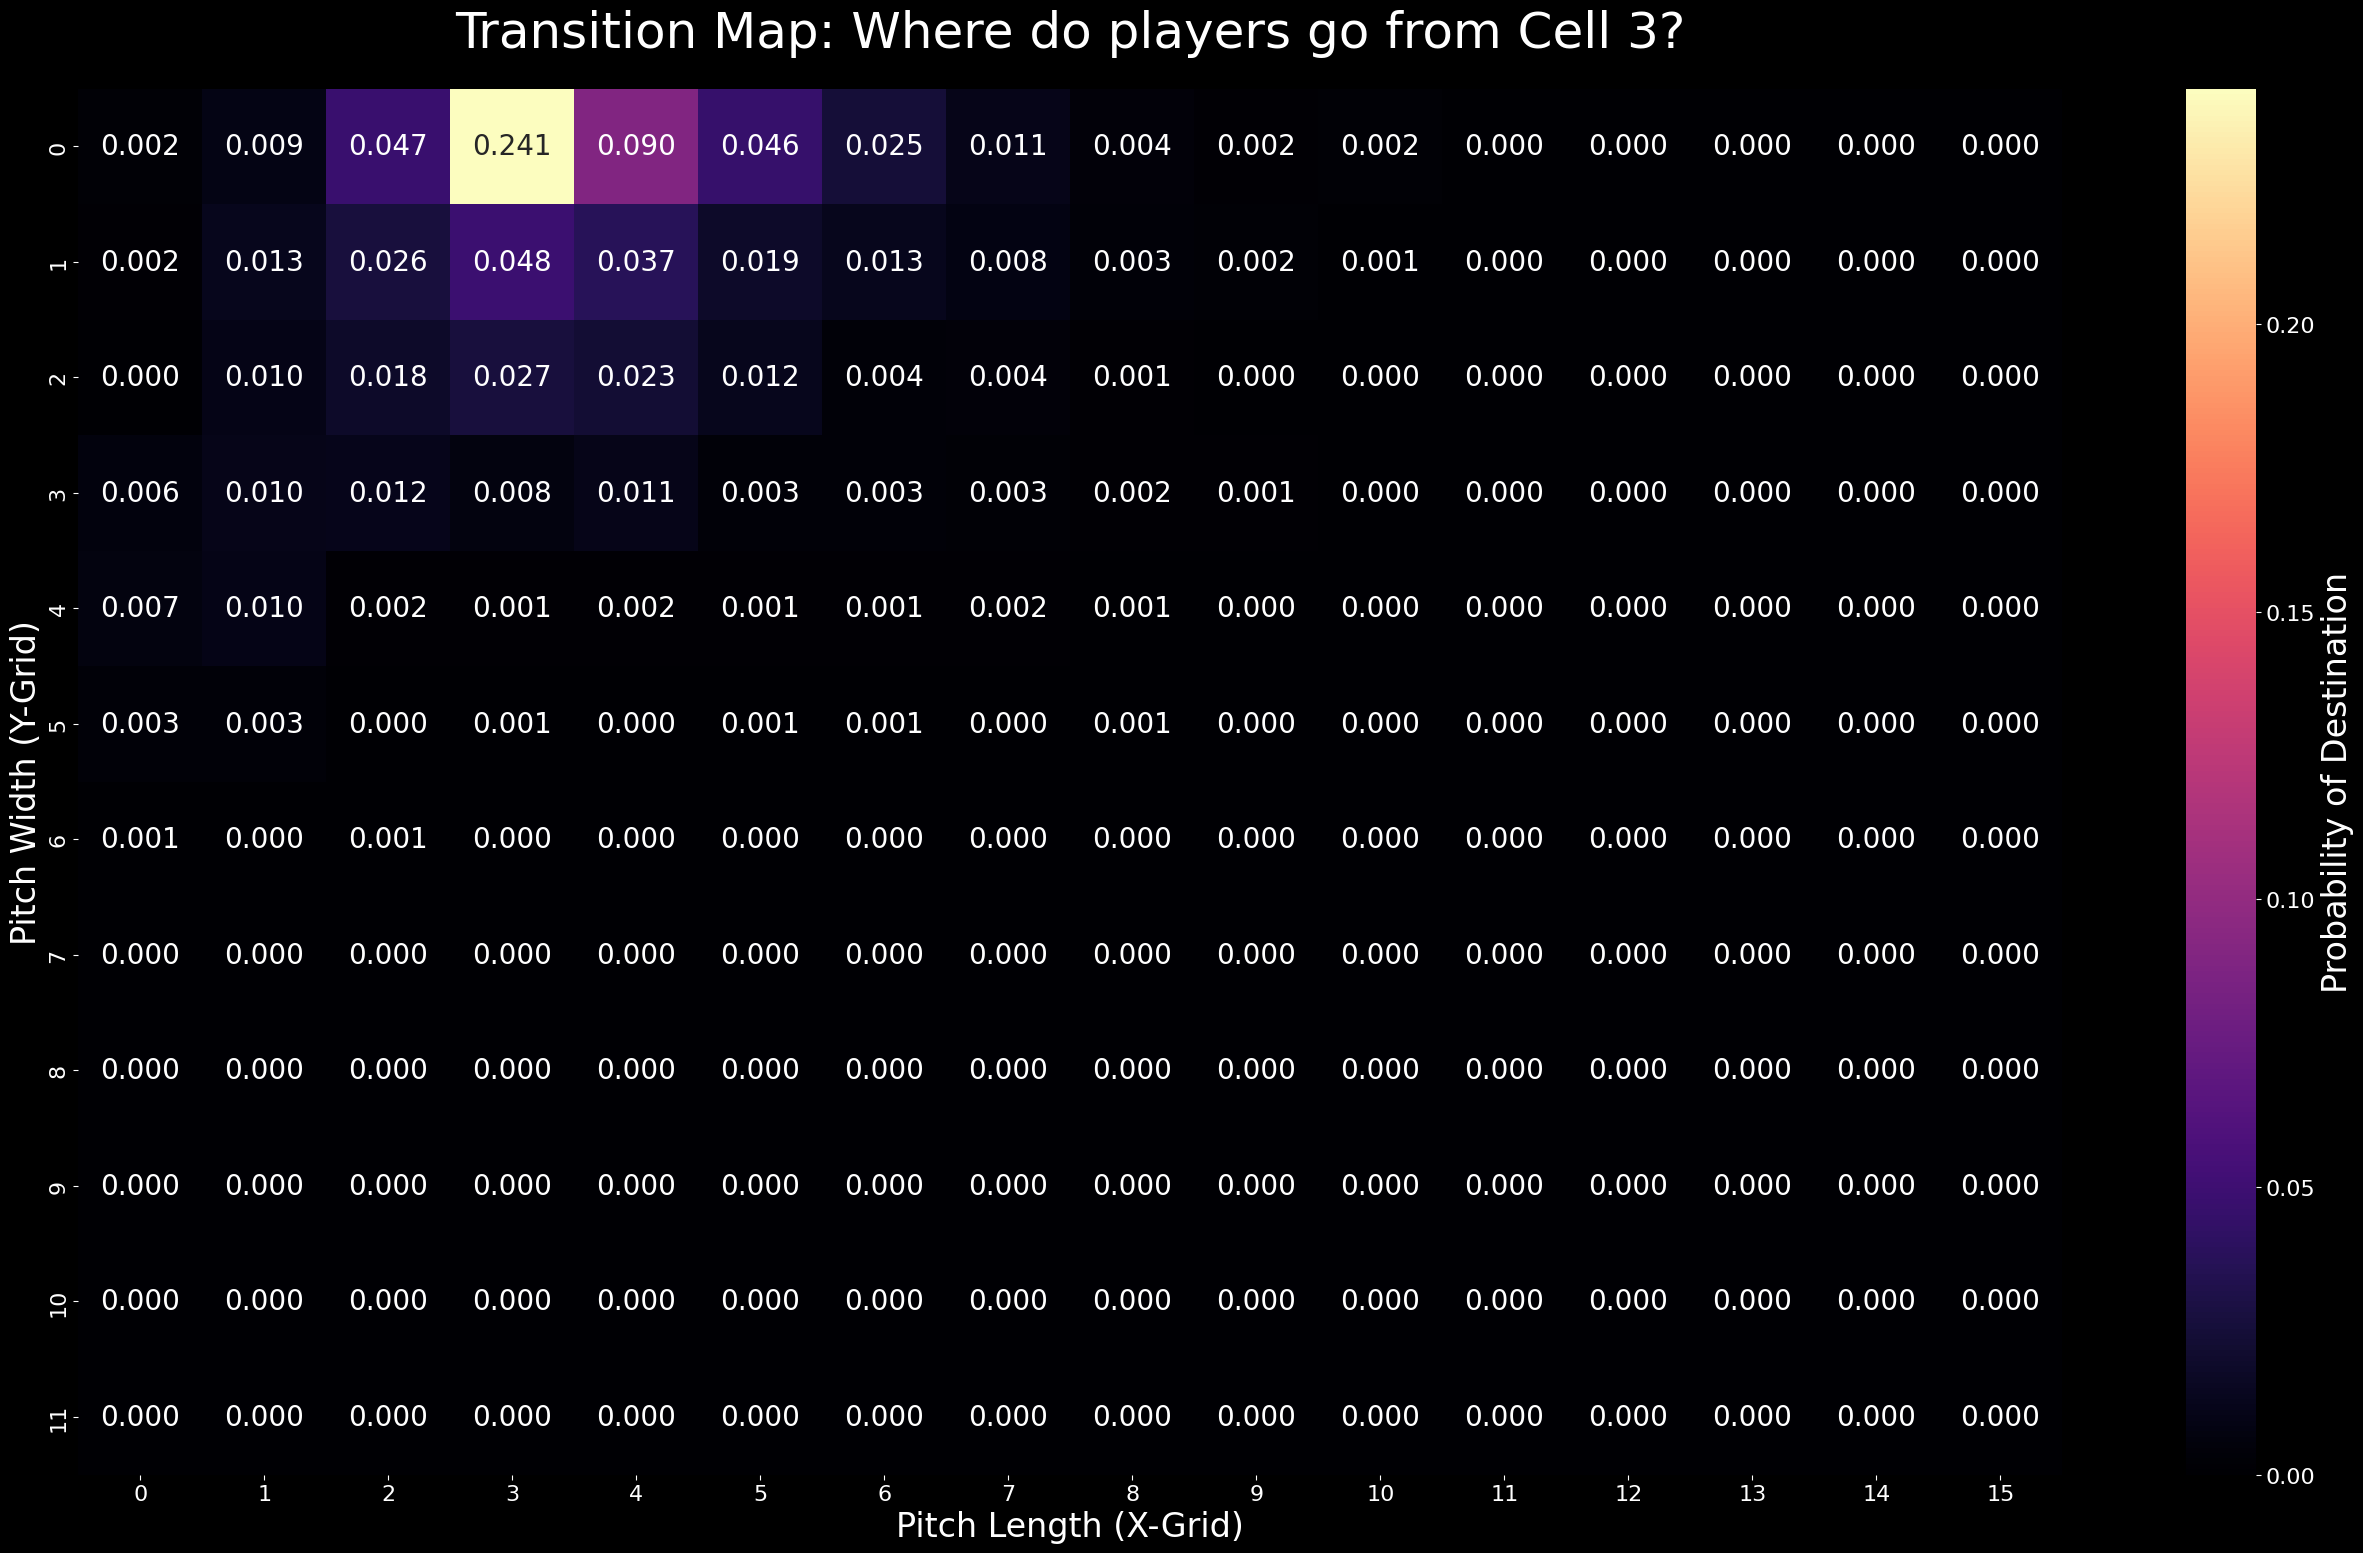

In [19]:
start_cell_idx = 3  # Change to the cell you want to observe

move_map = trans_matrix[start_cell_idx].reshape(M, N)

plot_pitch_grid(
    move_map, 
    title=f"Transition Map: Where do players go from Cell {start_cell_idx}?",
    label="Probability of Destination",
    fmt=".3f"
)

In [20]:
# Initialize xT grid with zeros
xt = np.zeros((M, N))
eps = 1e-5
diff = 1.0
iterations = 0

# Immediate reward (Goal Surface)
gs = p_scoring * p_shot

while diff > eps:
    total_payoff = np.zeros((M, N))
    
    # Flatten xt for matrix multiplication with transition matrix
    xt_flat = xt.flatten()
    
    for y in range(M):
        for x in range(N):
            s = y * N + x
            # Dot product of transition row for cell s and current xT values
            future_val = np.dot(trans_matrix[s], xt_flat)
            total_payoff[y, x] = future_val

    new_xt = gs + (p_move * total_payoff)
    diff = np.max(np.abs(new_xt - xt))
    xt = new_xt
    iterations += 1

print(f"xT calculation converged after {iterations} iterations.")

xT calculation converged after 45 iterations.


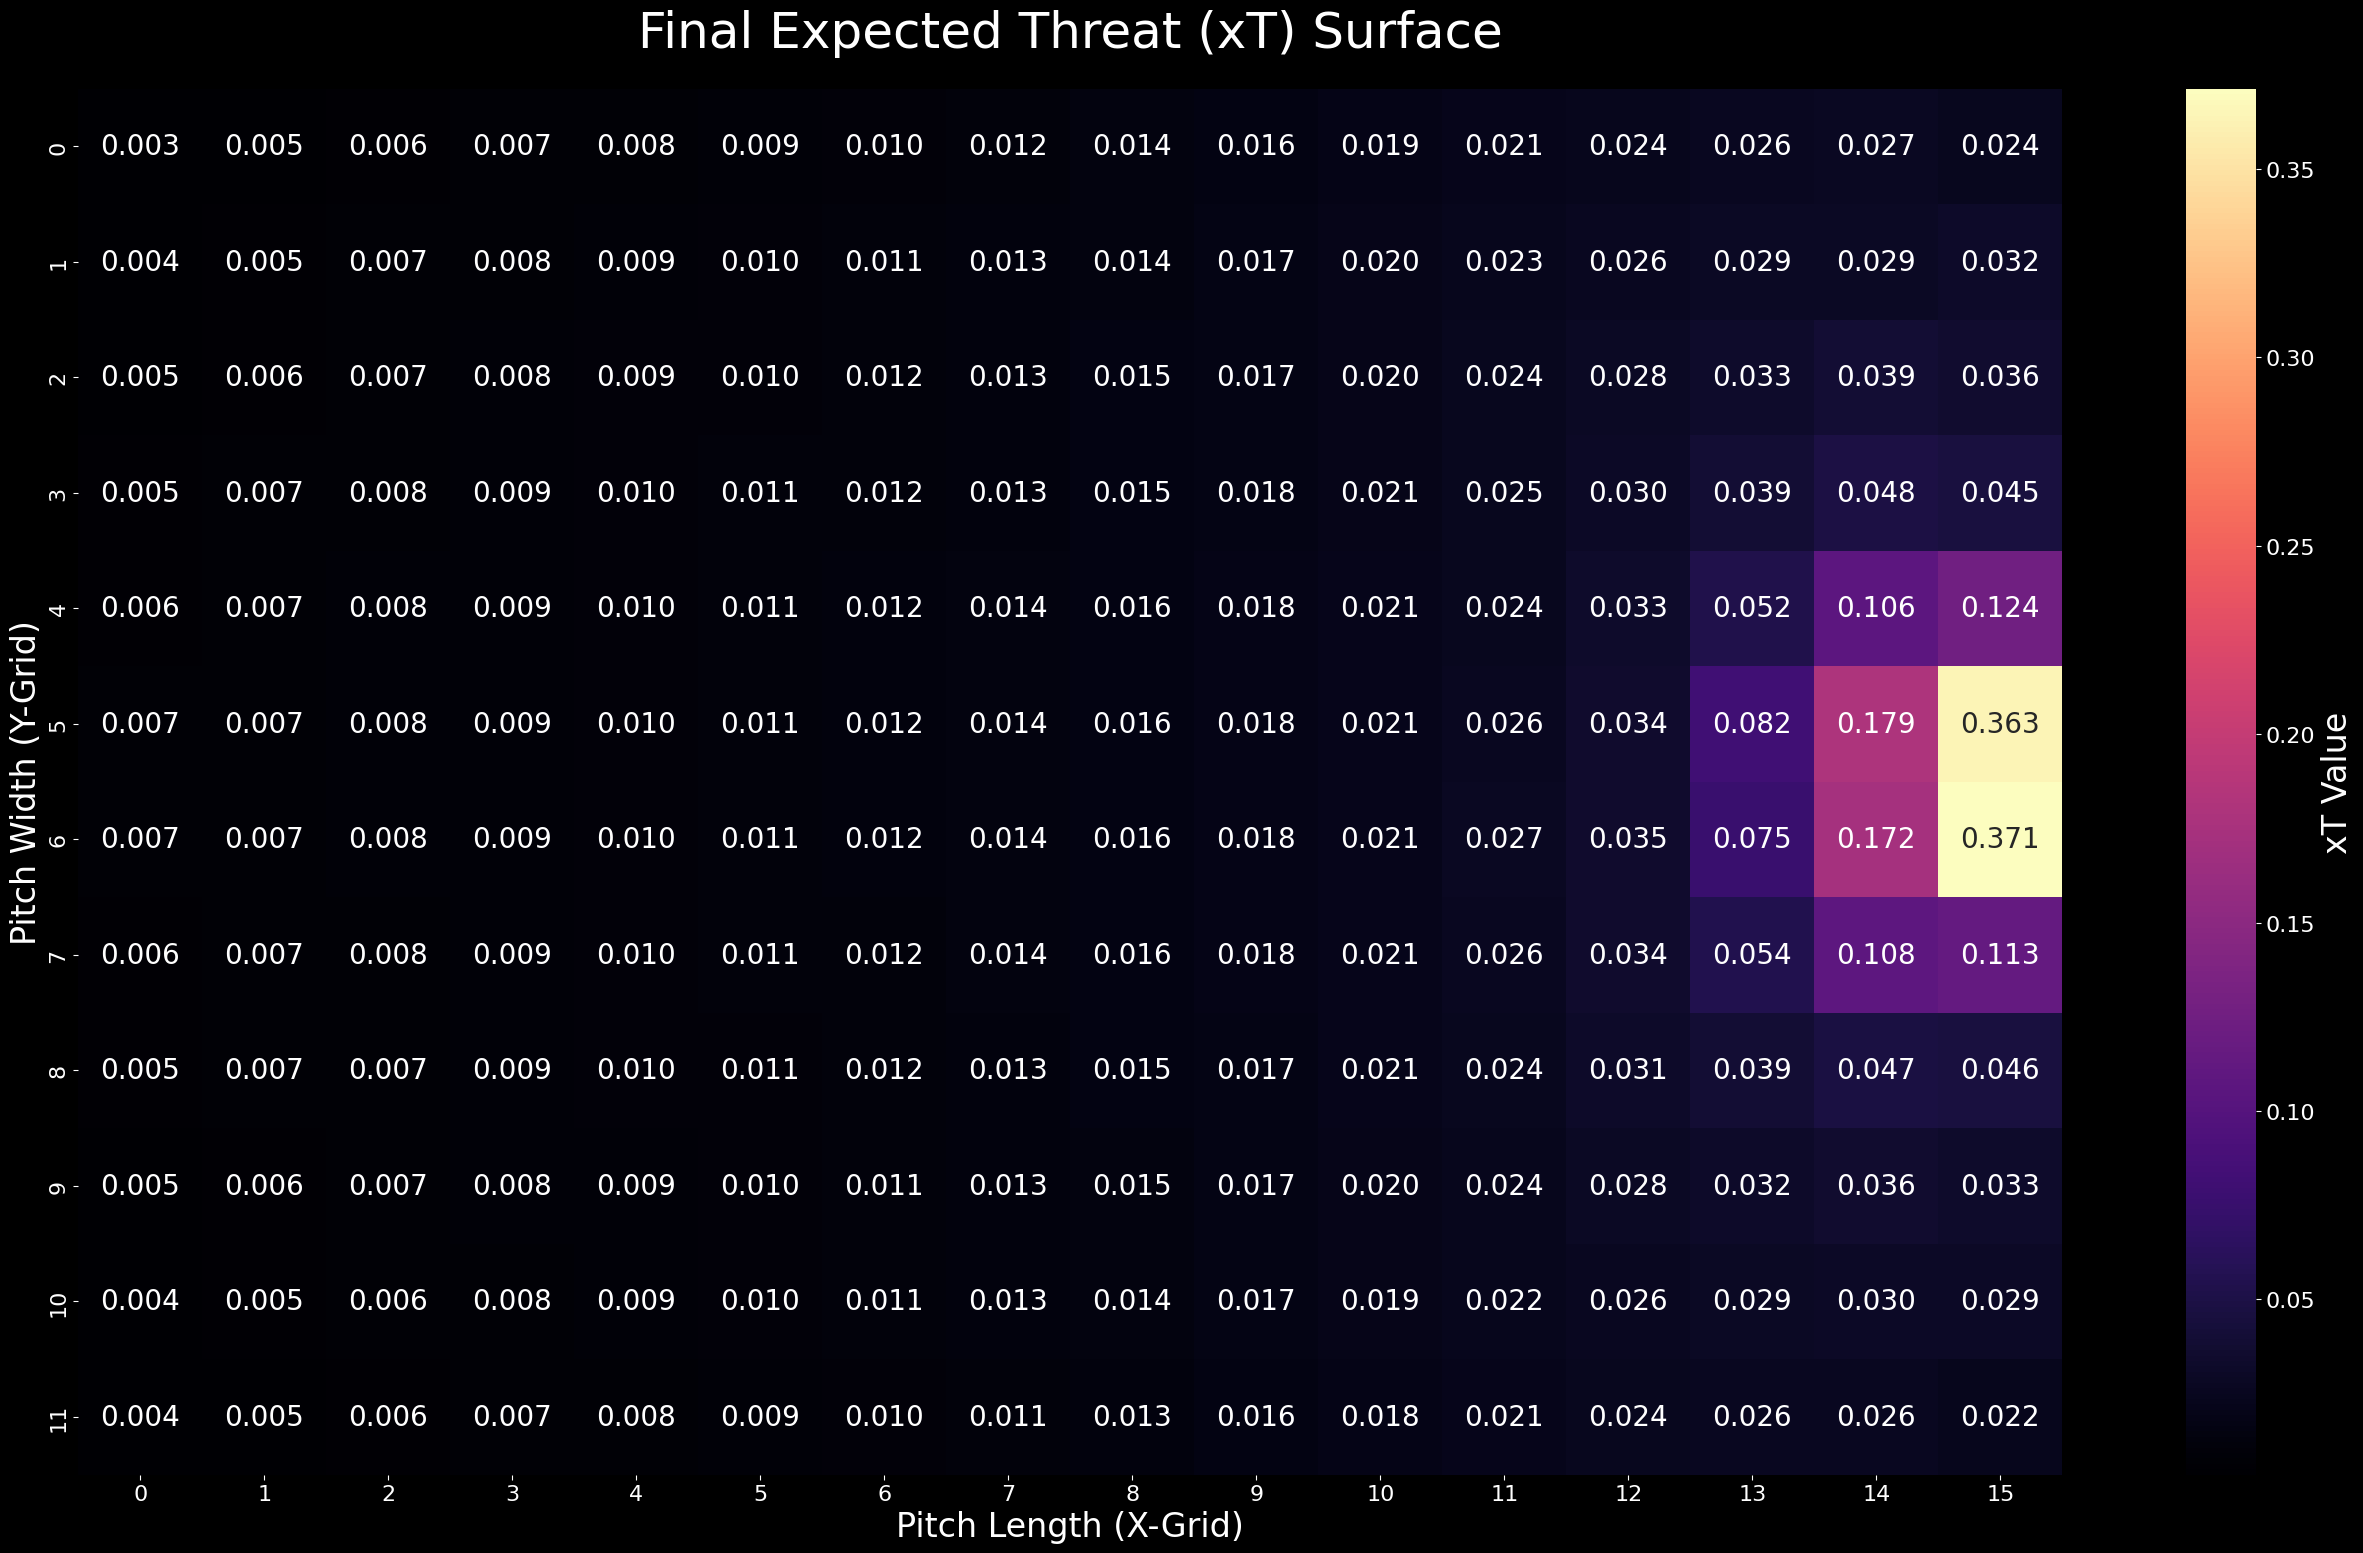

In [21]:
# Display final xT grid using the helper function
plot_pitch_grid(
    data=xt, 
    title="Final Expected Threat (xT) Surface", 
    label="xT Value", 
    fmt=".3f", 
    cmap="magma"
)

### BONUS 1: Higher Resolution xT Grid Setup

New Grid Resolution: 32x24 (768 states)


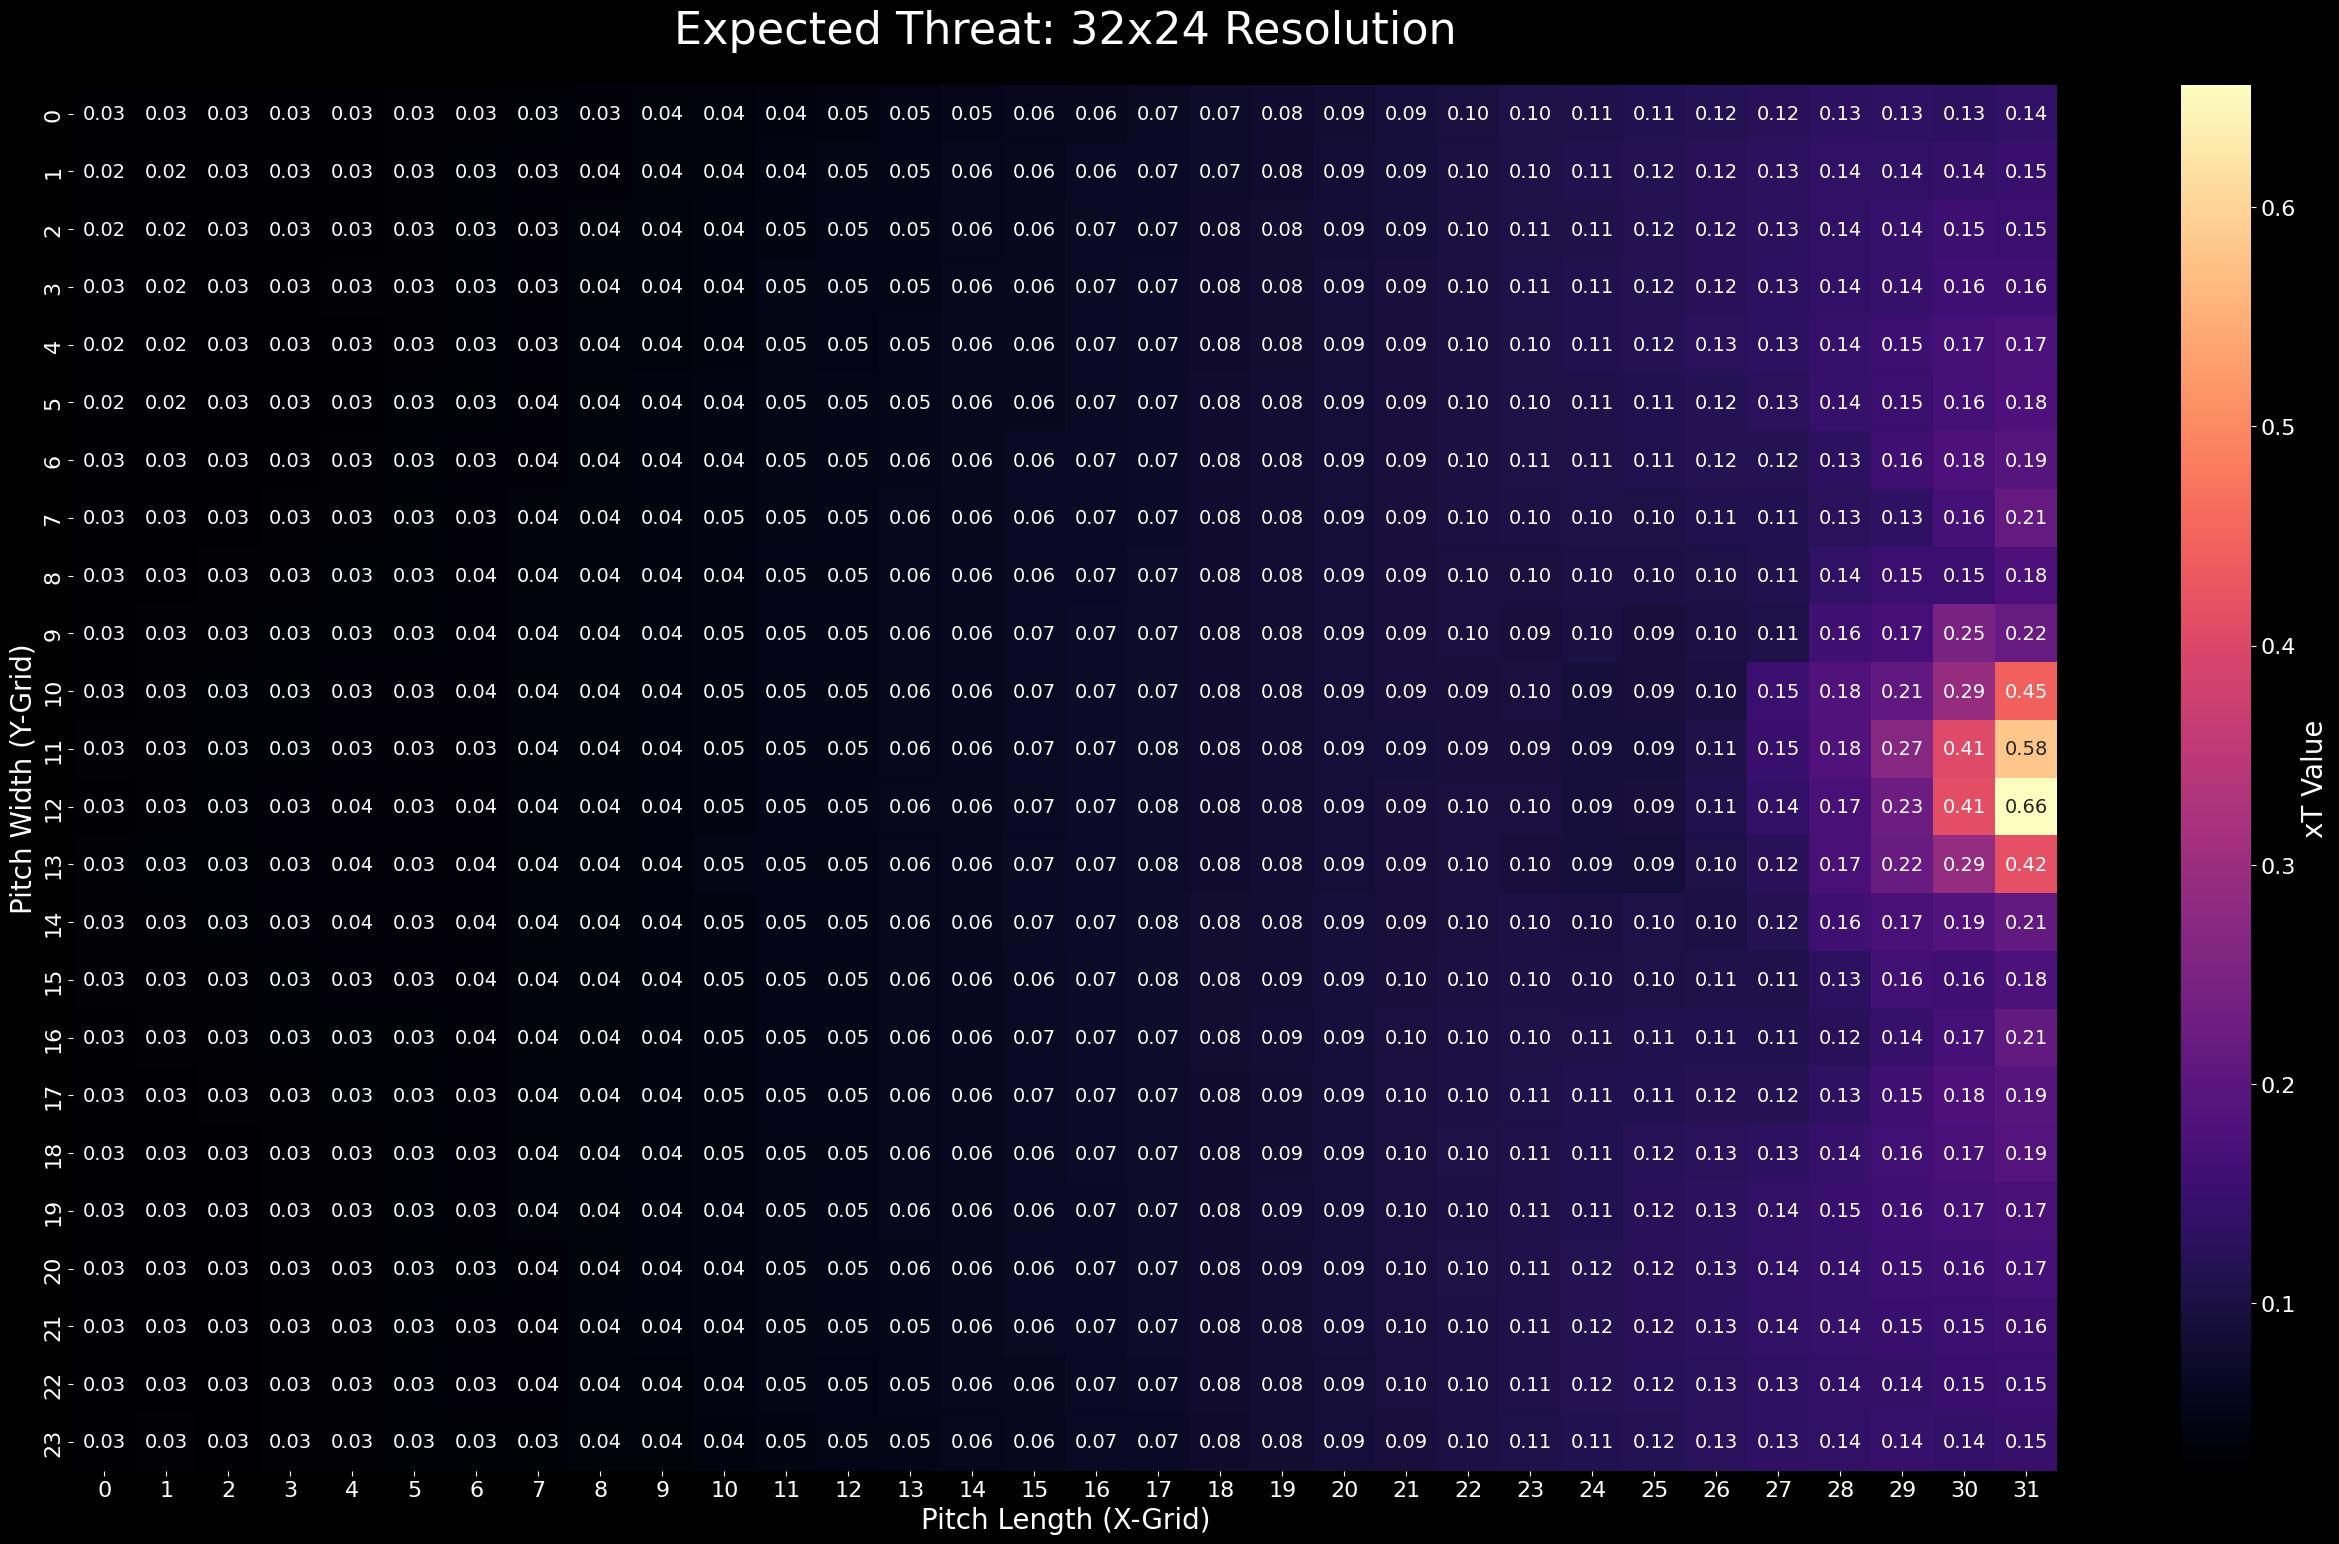

In [22]:
M_FINE = 24   # rows (y-axis)
N_FINE = 32   # cols (x-axis)

print(f"New Grid Resolution: {N_FINE}x{M_FINE} ({N_FINE * M_FINE} states)")

df_actions["start_cell_fine"] = get_flat_indexes(df_actions["start_x"], df_actions["start_y"], l=N_FINE, w=M_FINE)
df_actions["end_cell_fine"] = get_flat_indexes(df_actions["end_x"], df_actions["end_y"], l=N_FINE, w=M_FINE)

# Calculate Probabilities
total_actions_fine = count(df_actions["start_x"], df_actions["start_y"], N_FINE, M_FINE).flatten()
total_actions_fine = np.where(total_actions_fine == 0, 1, total_actions_fine) # avoid div by zero

# Shot and Goal Probabilities
df_shots = df_actions[df_actions["type_name"] == "Shot"]
s_fine = count(df_shots["start_x"], df_shots["start_y"], N_FINE, M_FINE).flatten() / total_actions_fine
g_fine = count(df_shots[df_shots["result"] == 1]["start_x"], df_shots[df_shots["result"] == 1]["start_y"], N_FINE, M_FINE).flatten()
g_fine = g_fine / np.where(count(df_shots["start_x"], df_shots["start_y"], N_FINE, M_FINE).flatten() == 0, 1, count(df_shots["start_x"], df_shots["start_y"], N_FINE, M_FINE).flatten())

# Move Probabilities
df_moves_fine = df_actions[df_actions["type_name"].isin(["Pass", "Carry", "Dribble"])]
m_fine = count(df_moves_fine["start_x"], df_moves_fine["start_y"], N_FINE, M_FINE).flatten() / total_actions_fine

# Transition Matrix
bin_count_fine = N_FINE * M_FINE
T_fine = np.zeros((bin_count_fine, bin_count_fine))
success_moves_fine = df_moves_fine[df_moves_fine["result"] == 1]
counts_fine = success_moves_fine.groupby(["start_cell_fine", "end_cell_fine"]).size().reset_index(name='count')

for _, row in counts_fine.iterrows():
    T_fine[int(row["start_cell_fine"]), int(row["end_cell_fine"])] = row["count"]

T_fine = T_fine / np.where(T_fine.sum(axis=1)[:, None] == 0, 1, T_fine.sum(axis=1)[:, None])

# Solve xT
xT_fine = np.zeros(bin_count_fine)
for i in range(20):
    xT_fine = (s_fine * g_fine) + (m_fine * (T_fine @ xT_fine))

plot_pitch_grid(xT_fine.reshape((M_FINE, N_FINE)), "Expected Threat: 32x24 Resolution", "xT Value", label_size=20, annot_size=14, title_size=32, tick_size=16)

### BONUS 2: xT with Separated Move Types

In [23]:
N, M = 16, 12  # Original grid size
df_actions["start_cell"] = get_flat_indexes(df_actions["start_x"], df_actions["start_y"], l=N, w=M)
df_actions["end_cell"] = get_flat_indexes(df_actions["end_x"], df_actions["end_y"], l=N, w=M)

total_acts = count(df_actions["start_x"], df_actions["start_y"], N, M).flatten().astype(float)
total_acts[total_acts == 0] = 1.0

In [24]:
def get_move_components(type_names):
    """Calculates probability and transition matrix for a specific set of move types."""
    subset = df_actions[df_actions["type_name"].isin(type_names)]
    p_move = count(subset["start_x"], subset["start_y"], N, M).flatten() / total_acts
    
    success = subset[subset["result"] == 1]
    T = np.zeros((N*M, N*M))
    # Efficiently map counts to matrix using index arrays
    c = success.groupby(["start_cell", "end_cell"]).size().reset_index(name='count')
    T[c["start_cell"].astype(int), c["end_cell"].astype(int)] = c["count"]
    
    row_sums = T.sum(axis=1, keepdims=True)
    return p_move, np.divide(T, row_sums, out=np.zeros_like(T), where=row_sums != 0)

In [25]:
# Calculate Probabilities & Matrices
p_pass, T_pass = get_move_components(["Pass"])
p_prog, T_prog = get_move_components(["Carry", "Dribble"])

# Shot/Goal Probability
df_shot = df_actions[df_actions["type_name"] == "Shot"]
p_shot = count(df_shot["start_x"], df_shot["start_y"], N, M).flatten() / total_acts
shot_counts = count(df_shot["start_x"], df_shot["start_y"], N, M).flatten()
p_goal_if_shot = count(df_shot[df_shot["result"] == 1]["start_x"], df_shot[df_shot["result"] == 1]["start_y"], N, M).flatten().astype(float)
p_goal_if_shot = np.divide(p_goal_if_shot, shot_counts, out=np.zeros_like(p_goal_if_shot), where=shot_counts != 0)

# Solve xT using the Separated Bellman Equation
shot_threat = p_shot * p_goal_if_shot
xT_sep = np.zeros(N * M)
for _ in range(20):
    xT_sep = shot_threat + (p_pass * (T_pass @ xT_sep)) + (p_prog * (T_prog @ xT_sep))

# Extract and Plot Contribution Components
pass_grid = (p_pass * (T_pass @ xT_sep)).reshape((M, N))
prog_grid = (p_prog * (T_prog @ xT_sep)).reshape((M, N))

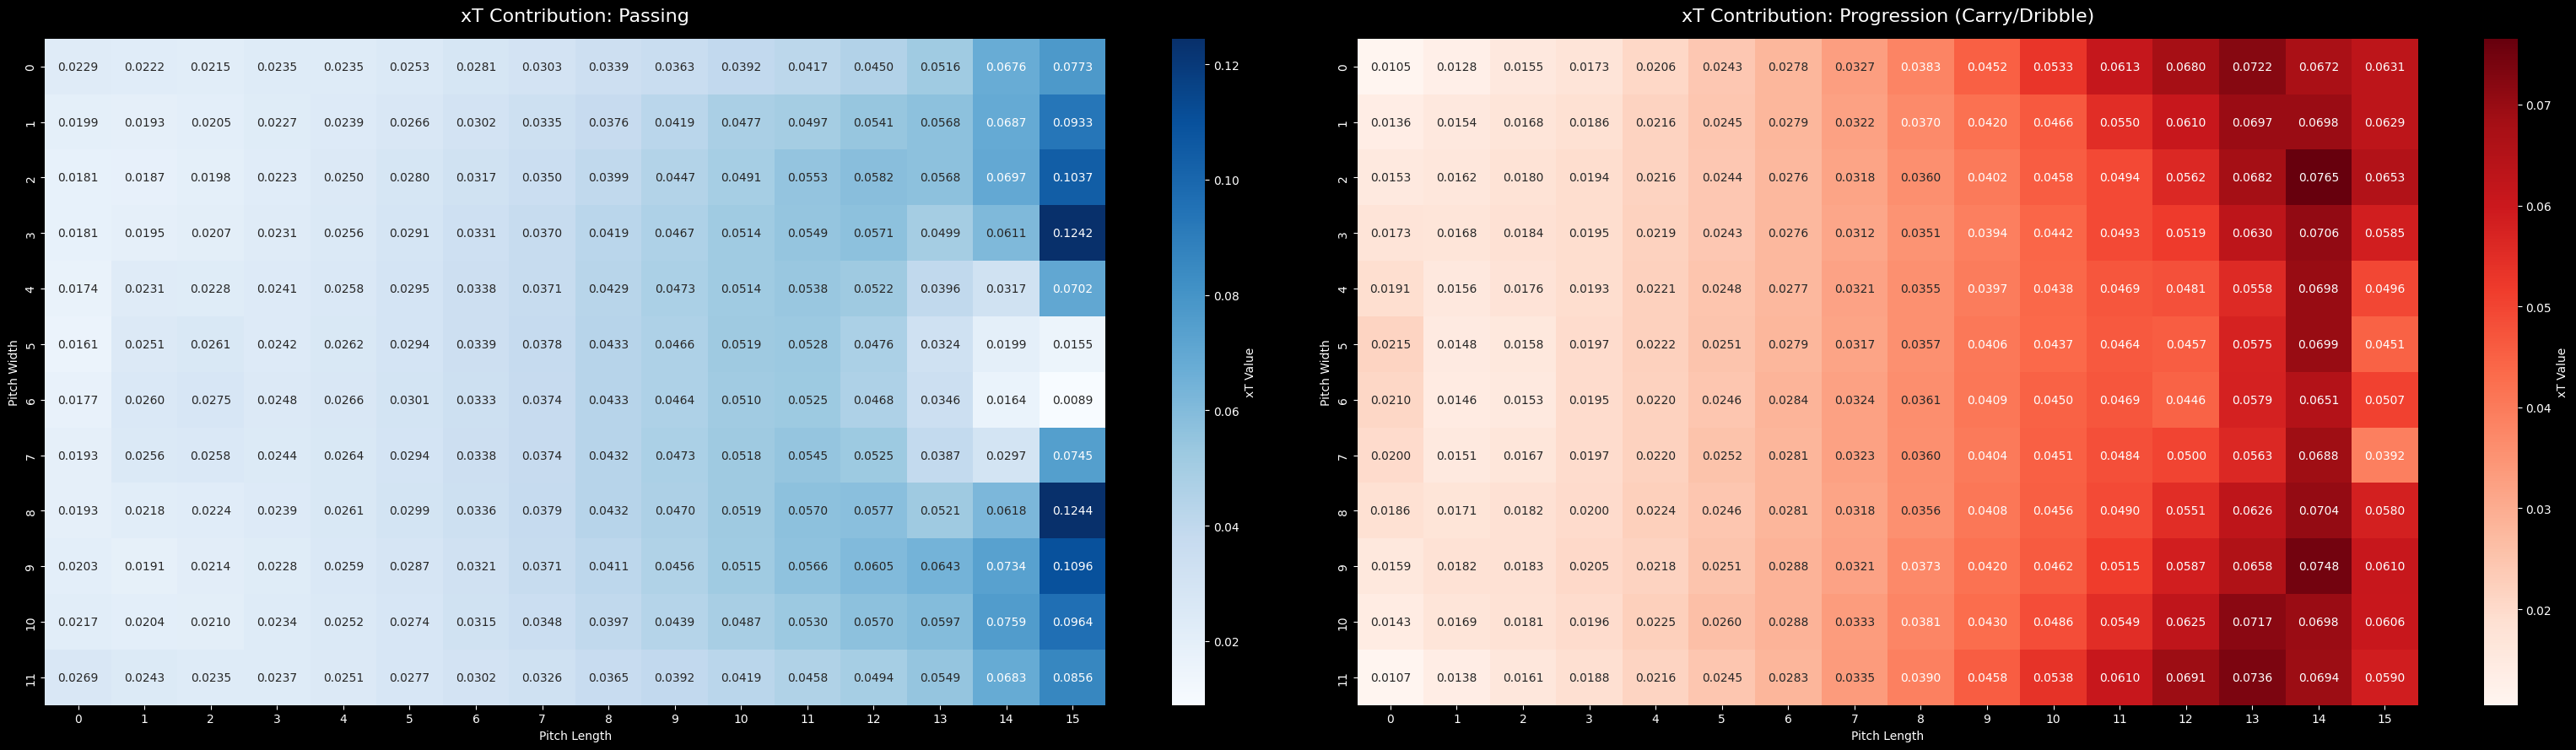

In [26]:
plt.style.use('dark_background')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32, 9))

# Helper to avoid repetitive styling
def style_ax(ax, data, title, cmap):
    sns.heatmap(data, annot=True, fmt=".4f", cmap=cmap, ax=ax, cbar_kws={'label': 'xT Value'})
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_xlabel("Pitch Length"), ax.set_ylabel("Pitch Width")

style_ax(ax1, pass_grid, "xT Contribution: Passing", "Blues")
style_ax(ax2, prog_grid, "xT Contribution: Progression (Carry/Dribble)", "Reds")

plt.tight_layout()
plt.show()